In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df=pd.read_csv('train.csv').copy()

In [5]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(42000, 785)

We have a total of 42000 samples, each with 784 (28*28) pixels.

In [7]:
#To work with numpy arrays
data=np.array(df)

In [8]:
m,n = data.shape
np.random.shuffle(data)

In [9]:
data_dev=data[0:1000].T  #Taking first 1000 samples for testing
X_dev=data_dev[1:n]
Y_dev=data_dev[0]

data_train=data[1000:m].T #Transpose cause we want samples as columns
Y_train=data_train[0]
X_train=data_train[1:n]
X_train = X_train / 255.
X_dev = X_dev / 255.


In [10]:
X_train.shape

(784, 41000)

In [11]:
Y_train.shape


(41000,)

In [12]:
# Initialising parameters
# Updating parameters
def init_params():
    W1 = np.random.rand(10, 784) - 0.5 #Taking 10 nodes in the hidden layer
    b1 = np.random.rand(10,1) -0.5
    W2 = np.random.rand(10,10) - 0.5
    b2 = np.random.rand(10,1) - 0.5
    return W1, b1, W2, b2


subtracting -0.5 from randomly initialised values because rand gives values in range 0 to 1 and having weights in the range -0.5 to 0.5 centres the weights around the mean which helps in balanced activations, better gradient flow and faster convergence

Forward propagation

Z[1]=W[1]X+b[1]
 
A[1]=gReLU(Z[1]))
 
Z[2]=W[2]A[1]+b[2]
 
A[2]=gsoftmax(Z[2])

In [13]:
# Forward Propagation

def ReLU(Z):
    return np.maximum(0,Z) #maximum compares each element of Z with 0 

def softmax(Z):
    A = np.exp(Z) / sum(np.exp(Z))
    return A
    
def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2


Backward propagation

dZ[2]=A[2]−Y
 
dW[2]=1mdZ[2]A[1]T
 
dB[2]=1mΣdZ[2]
 
dZ[1]=W[2]TdZ[2].∗g[1]′(z[1])
 
dW[1]=1mdZ[1]A[0]T
 
dB[1]=1mΣdZ[1]

In [14]:
# Back propagation

def one_hot(Y, num_classes=10):
    one_hot_Y = np.zeros((num_classes, Y.size))
    one_hot_Y[Y, np.arange(Y.size)] = 1
    return one_hot_Y


def ReLU_deriv(Z):
    return Z > 0

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y):
    m = X.shape[1]
    
    one_hot_Y = one_hot(Y)
    
    dZ2 = A2 - one_hot_Y
    dW2 = 1/m * dZ2.dot(A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)

    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)
    dW1 = 1/m * dZ1.dot(X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2



Parameter updates

W[2]:=W[2]−αdW[2]
 
b[2]:=b[2]−αdb[2]
 
W[1]:=W[1]−αdW[1]
 
b[1]:=b[1]−αdb[1]

In [15]:
# Updating parameters
def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha):
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [16]:
# Creating mini batches for SGD
def create_mini_batches(X, Y, batch_size):
    m = X.shape[1]
    mini_batches = []

    permutation = np.random.permutation(m)
    X_shuffled = X[:, permutation]
    Y_shuffled = Y[permutation]

    for i in range(0, m, batch_size):
        X_batch = X_shuffled[:, i:i+batch_size]
        Y_batch = Y_shuffled[i:i+batch_size]
        mini_batches.append((X_batch, Y_batch))

    return mini_batches


Cross entropy formula for softmax classification:

J=−(1/m)* ∑[i=1-m] ∑[j=1-c] y[j](i) log(a[j](i))

In [17]:
# Gradient Descent

def get_predictions(A2):
    return np.argmax(A2, 0) #gives max probabilty for each column 

def get_accuracy(predictions, Y):
    return np.mean(predictions == Y) 

def compute_cost(A2, Y):
    m = Y.size
    one_hot_Y = one_hot(Y)
    log_probs = np.log(A2)
    cost = -np.sum(one_hot_Y * log_probs) / m
    return cost

def sgd_training(X, Y, alpha, iters, batch_size):
    W1, b1, W2, b2 = init_params()

    accuracies = []
    costs = []
    iterations = []

    for i in range(iters):

        mini_batches = create_mini_batches(X, Y, batch_size)

        for X_batch, Y_batch in mini_batches:
            Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_batch)
            dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X_batch, Y_batch)
            W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        if i % 10 == 0:
            _, _, _, A2_full = forward_prop(W1, b1, W2, b2, X)
            predictions = get_predictions(A2_full)
            acc = get_accuracy(predictions, Y)
            cost = compute_cost(A2_full, Y)

            accuracies.append(acc)
            costs.append(cost)
            iterations.append(i)

    return W1, b1, W2, b2, accuracies, costs, iterations



In [18]:
W1, b1, W2, b2, accuracies, cost, iterations = sgd_training(
    X_train, Y_train,
    alpha=0.1,
    iters=100,
    batch_size=64
)


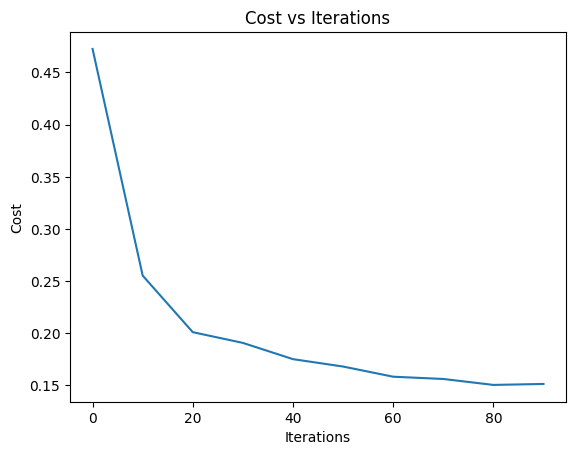

In [19]:
plt.plot(iterations, cost)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost vs Iterations")
plt.show()


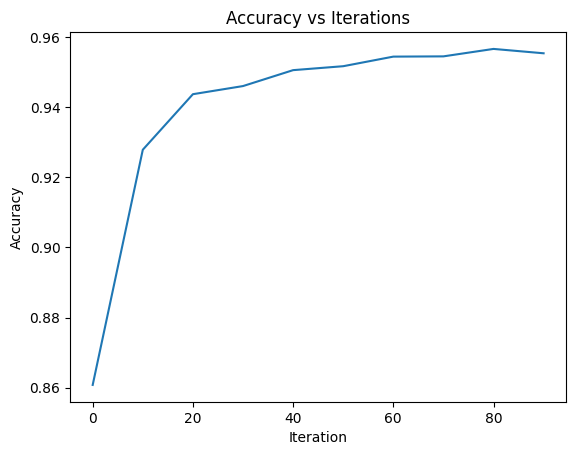

In [20]:

plt.plot(iterations, accuracies)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Iterations")
plt.show()

In [21]:
print("Accuracy of the model ", accuracies[-1])

Accuracy of the model  0.9553170731707317


In [22]:
# Testing
def make_predictions(X, W1, b1, W2, b2):
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [3]
Label:  3


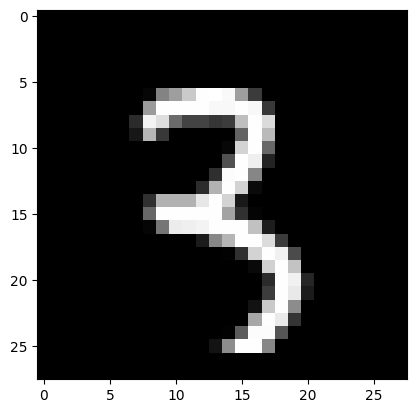

In [23]:
test_prediction(232, W1, b1, W2, b2)

Prediction:  [2]
Label:  2


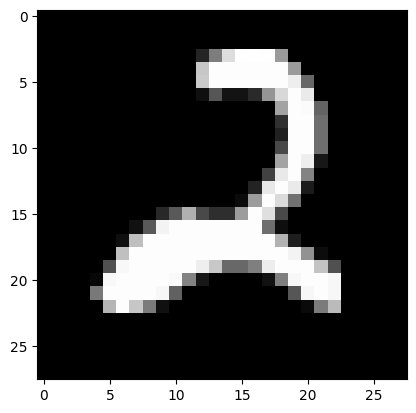

In [24]:
test_prediction(67, W1, b1, W2, b2)

Prediction:  [7]
Label:  7


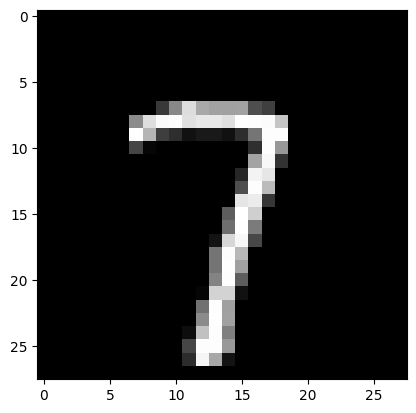

In [25]:
test_prediction(7891, W1, b1, W2, b2)

Prediction:  [7]
Label:  7


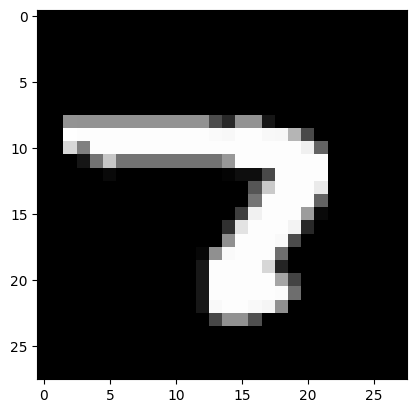

In [26]:
test_prediction(106, W1, b1, W2, b2)

In [27]:
def confusion_matrix(predictions, Y, num_classes=10):
    cm = np.zeros((num_classes, num_classes), dtype=int)

    for true, pred in zip(Y, predictions):
        cm[true][pred] += 1

    return cm


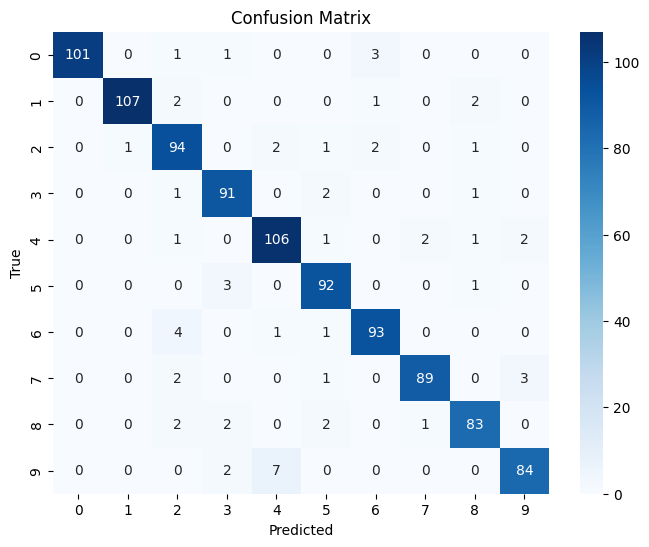

In [34]:
# Predictions on training set
Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X_dev)
predictions = get_predictions(A2)

cm = confusion_matrix(predictions, Y_dev)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()



In [29]:
 #Tesing on the dev set

dev_predictions = make_predictions(X_dev, W1, b1, W2, b2)
get_accuracy(dev_predictions, Y_dev)

np.float64(0.94)

In [30]:
def precision_recall_f1(cm):
    num_classes = cm.shape[0]

    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for i in range(num_classes):
        TP = cm[i, i]
        FP = np.sum(cm[:, i]) - TP
        FN = np.sum(cm[i, :]) - TP

        precision[i] = TP / (TP + FP) if (TP + FP) != 0 else 0
        recall[i] = TP / (TP + FN) if (TP + FN) != 0 else 0

        if precision[i] + recall[i] != 0:
            f1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
        else:
            f1[i] = 0

    return precision, recall, f1


In [31]:
precision, recall, f1 = precision_recall_f1(cm)

for i in range(10):
    print(f"Digit {i}:")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall:    {recall[i]:.4f}")
    print(f"F1-score:  {f1[i]:.4f}")
    print()


Digit 0:
Precision: 1.0000
Recall:    0.9528
F1-score:  0.9758

Digit 1:
Precision: 0.9907
Recall:    0.9554
F1-score:  0.9727

Digit 2:
Precision: 0.8785
Recall:    0.9307
F1-score:  0.9038

Digit 3:
Precision: 0.9192
Recall:    0.9579
F1-score:  0.9381

Digit 4:
Precision: 0.9138
Recall:    0.9381
F1-score:  0.9258

Digit 5:
Precision: 0.9200
Recall:    0.9583
F1-score:  0.9388

Digit 6:
Precision: 0.9394
Recall:    0.9394
F1-score:  0.9394

Digit 7:
Precision: 0.9674
Recall:    0.9368
F1-score:  0.9519

Digit 8:
Precision: 0.9326
Recall:    0.9222
F1-score:  0.9274

Digit 9:
Precision: 0.9438
Recall:    0.9032
F1-score:  0.9231

